# 1. Intro

* nama  : Iqbal Awis Nurdiansyah
* batch : RMT-19

Background : An NGO institution is committed to fighting poverty and providing basic facilities and assistance to communities in less developed countries. Recently, they have been able to raise around $10 million. The CEO of the NGO needs to decide how to use this money strategically and effectively. A significant issue that arises when making this decision is related to the selection of the country that is most in need of assistance.

Create an Unsupervised Learning machine learning model using KMeans to cluster these countries. Clearly state which country you recommend to the CEO in the Conclusion section."

Objective : Give recomendation to CEO Country that need Finalcial Aid

# 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

#model
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

#evaluation
from sklearn.metrics.pairwise import cosine_similarity

#Saving
import joblib
import pickle
import json


# 3. Data Loading

In [2]:
df = pd.read_csv('humanitarian-aid.csv')

In [3]:
df.head(10)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   country          167 non-null    object 
 1   child_mortality  167 non-null    float64
 2   exports          167 non-null    float64
 3   health           167 non-null    float64
 4   imports          167 non-null    float64
 5   income           167 non-null    int64  
 6   inflation        167 non-null    float64
 7   life_expectancy  167 non-null    float64
 8   total_fertility  167 non-null    float64
 9   gdpp             167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [5]:
# check duplicated data
df.duplicated(keep=False).sum()

0

# 4. EDA

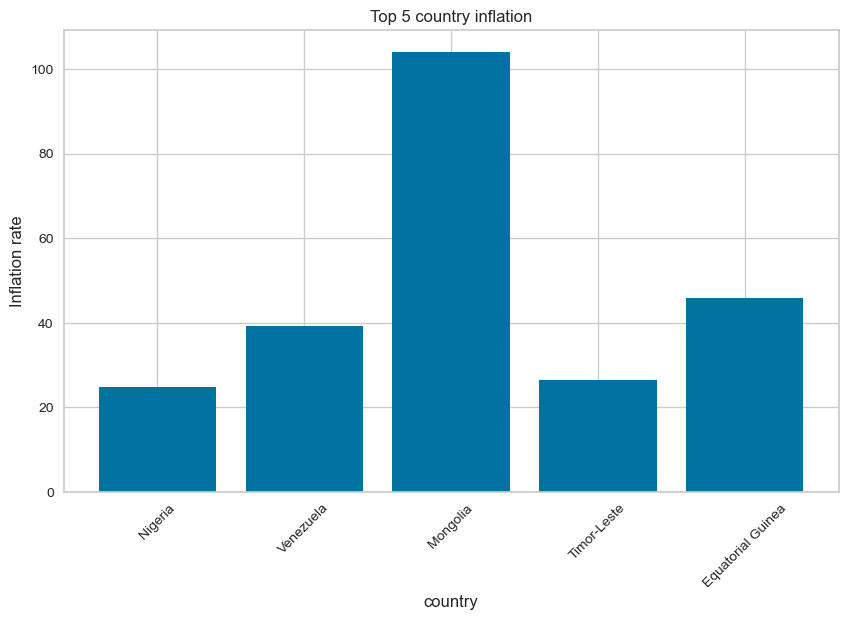

In [44]:
#top inflation
top_5_countries = df.sort_values(by='inflation', ascending=False).head(5)['country']


plt.figure(figsize=(10, 6))
plt.bar(top_5_countries, df[df['country'].isin(top_5_countries)]['inflation'])
plt.xlabel('country')
plt.ylabel('Inflation rate')
plt.title('Top 5 country inflation')
plt.xticks(rotation=45)
plt.show()

`Mongolia is the country with the highest inflation rate`

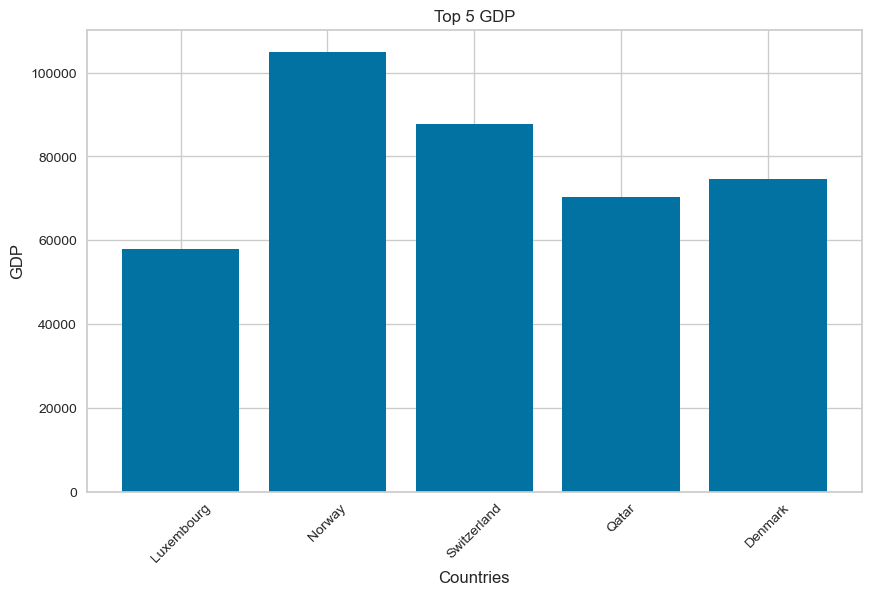

In [7]:

top_5_countries_gdpp = df.sort_values(by='gdpp', ascending=False).head(5)['country']

plt.figure(figsize=(10, 6))
plt.bar(top_5_countries_gdpp, df[df['country'].isin(top_5_countries_gdpp)]['gdpp'])
plt.xlabel('Countries')
plt.ylabel('GDP')
plt.title('Top 5 GDP')
plt.xticks(rotation=45)
plt.show()

`Norway is the country with the highest GDP per capita`

# 5. Feature Engineering

In [8]:
data = df.copy()

## Missing Value

In [9]:
# check missing value
data.isnull().sum()

country            0
child_mortality    0
exports            0
health             0
imports            0
income             0
inflation          0
life_expectancy    0
total_fertility    0
gdpp               0
dtype: int64

In [10]:
# drop country coloums
data.drop('country' , inplace=True , axis=1)

drop coloumn country 

In [11]:
data

,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...
162,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


## Handling Outlier

In [12]:
# function to check disributed data
def diagnostic_plots(data, variable1, variable2, variable3, variable4):
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable1], bins=20)
    plt.title('Histogram of ' + variable1)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data[variable1])
    plt.title('Boxplot of ' + variable1)
    
    print('Skewness Value of', variable1,':', data[variable1].skew() )
    
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable2], bins=20)
    plt.title('Histogram of ' + variable2)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data[variable2])
    plt.title('Boxplot of ' + variable2)
    
    print('Skewness Value of', variable2,':', data[variable2].skew() )
    
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable3], bins=20)
    plt.title('Histogram of ' + variable3)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data[variable3])
    plt.title('Boxplot of ' + variable3)

    print('Skewness Value of', variable3,':', data[variable3].skew() )

    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable4], bins=20)
    plt.title('Histogram of ' + variable4)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data[variable4])
    plt.title('Boxplot of ' + variable4)    
    
    print('Skewness Value of', variable4,':', data[variable4].skew() )

    plt.figure(figsize=(18, 4))
    
    plt.show()

Skewness Value of child_mortality : 1.4507735387555047
Skewness Value of exports : 2.4458240051613496
Skewness Value of health : 0.7057460547100981
Skewness Value of imports : 1.90527571988626


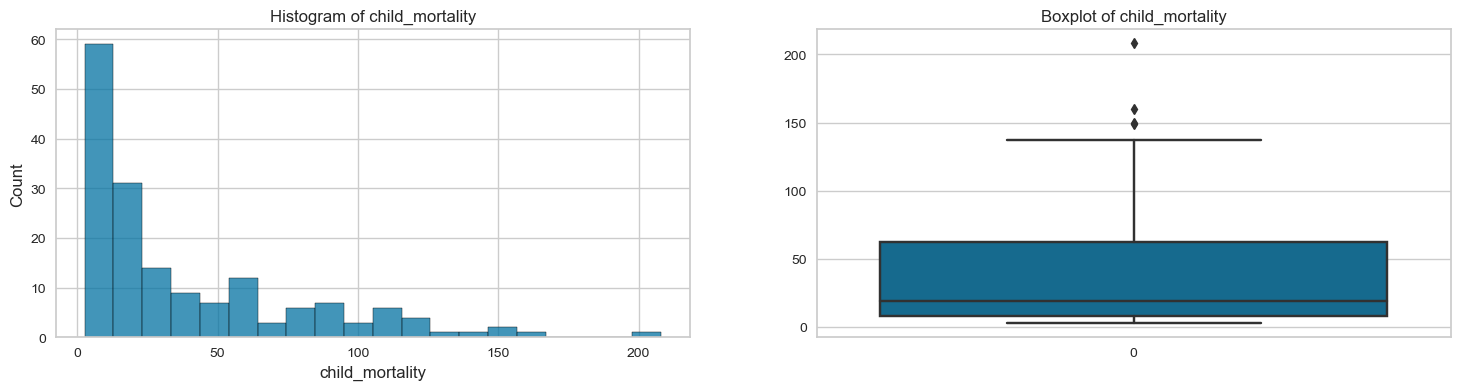

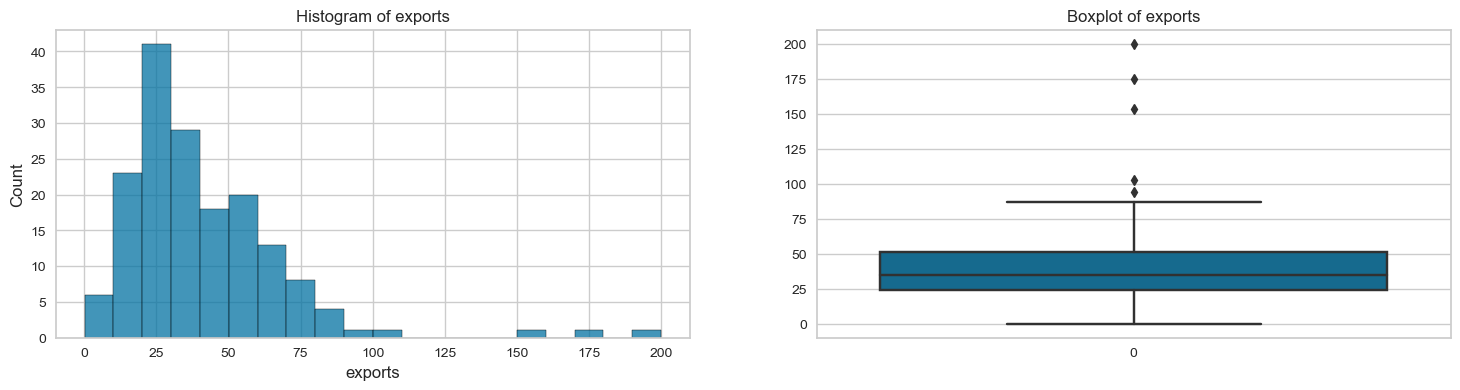

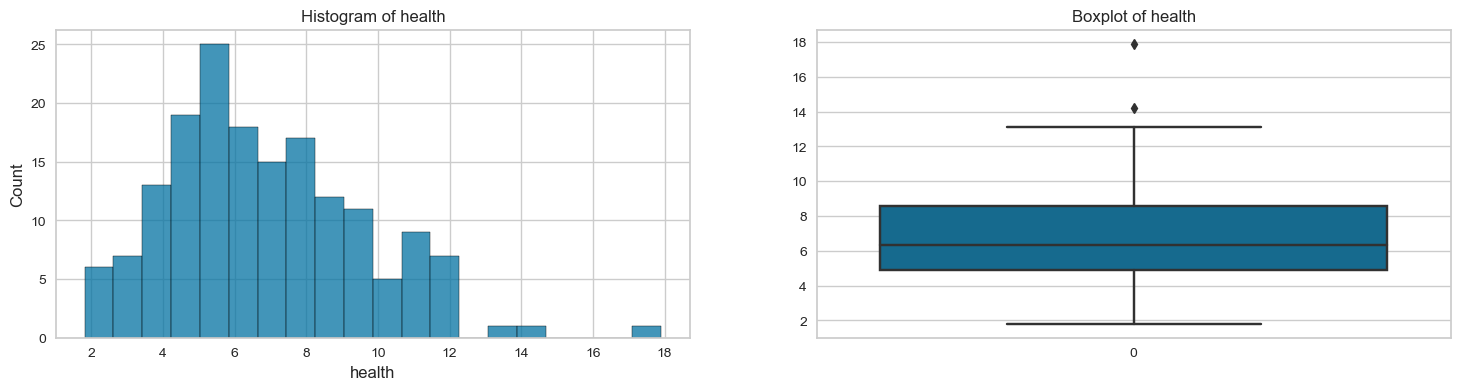

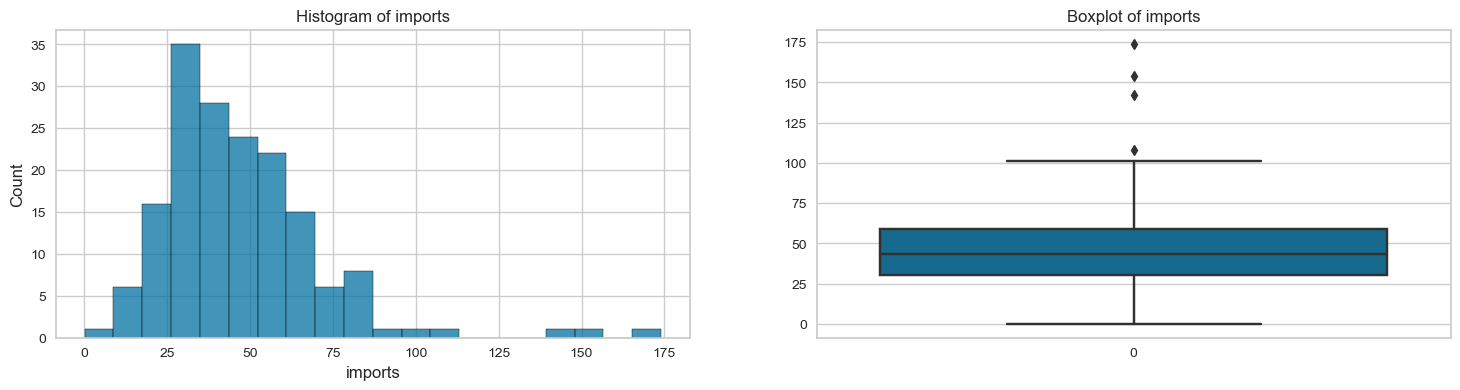

<Figure size 1800x400 with 0 Axes>

In [13]:
diagnostic_plots(data,'child_mortality','exports','health','imports')	 

Skewness Value of income : 2.231479607767527
Skewness Value of inflation : 5.154049359697971
Skewness Value of life_expectancy : -0.9709955819991258
Skewness Value of total_fertility : 0.9670916808050207


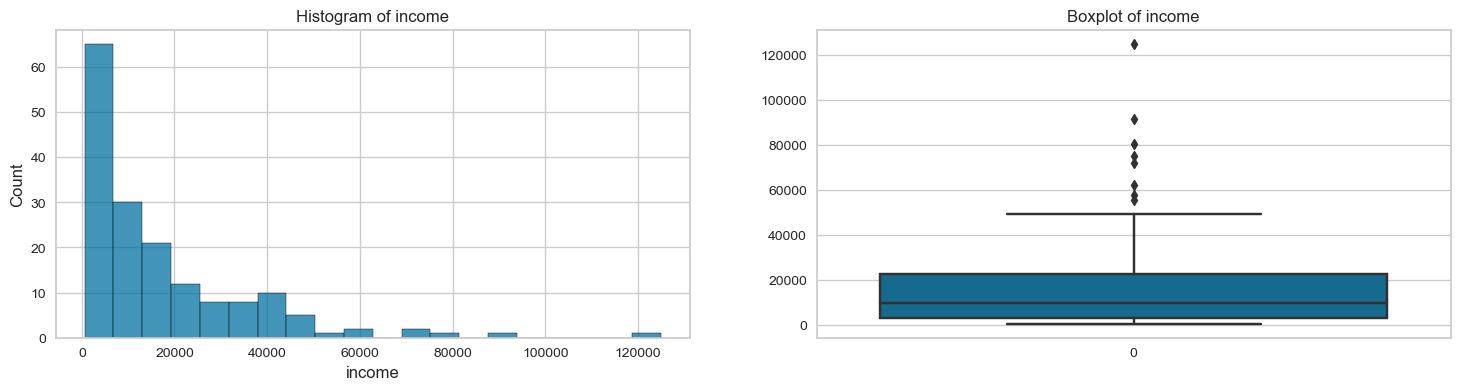

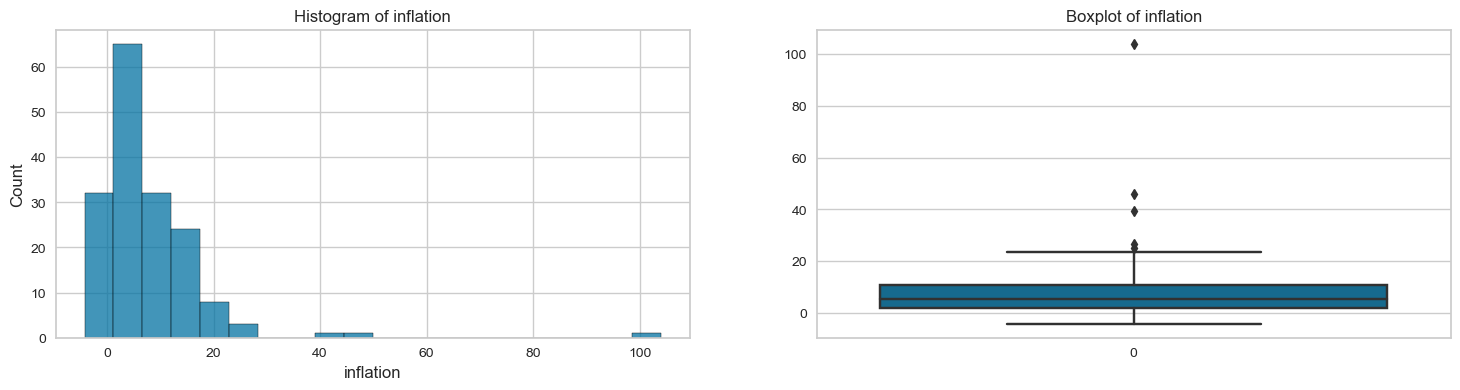

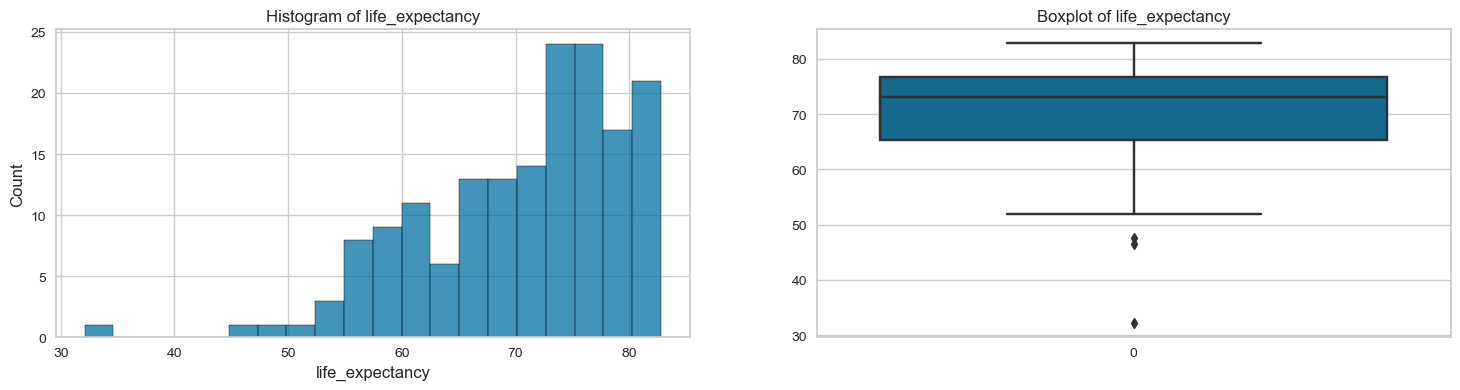

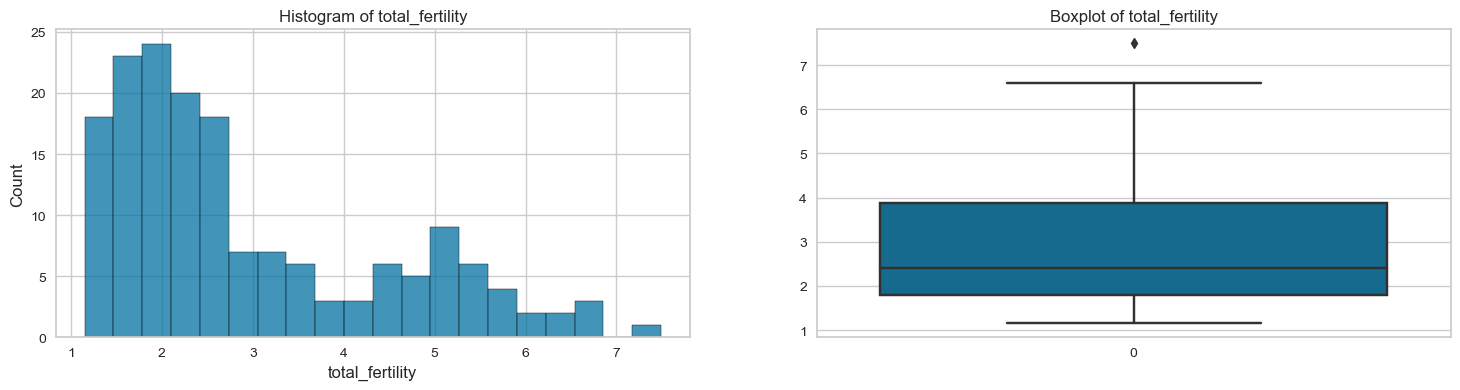

<Figure size 1800x400 with 0 Axes>

In [14]:
diagnostic_plots(data, 'income','inflation','life_expectancy','total_fertility')

In [15]:
def diagnostic_plots1(data, variable1,):
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data[variable1], bins=20)
    plt.title('Histogram of ' + variable1)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data[variable1])
    plt.title('Boxplot of ' + variable1)
    
    print('Skewness Value of', variable1,':', data[variable1].skew() )

Skewness Value of gdpp : 2.2180514519497163


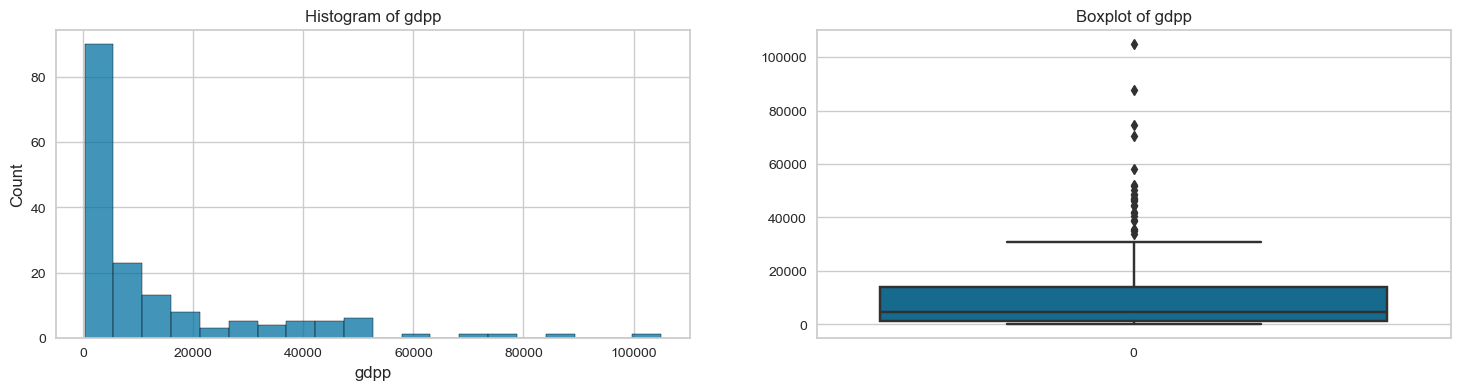

In [16]:
diagnostic_plots1(data,'gdpp')

In [17]:
#handling outlier using winsoriser
winsorizer = Winsorizer(capping_method='iqr',
                        tail='both',
                        fold=1.5,
                        variables=['child_mortality','exports','health','imports','income','inflation'	,'life_expectancy','total_fertility','gdpp'])
winsorizer.fit(data)
data=winsorizer.transform(data)


## Scaling

In [18]:
#because the data is not normally we using MinMaxScaler to scaling 
scaler = MinMaxScaler()

In [19]:
scaler.fit(data)
data_sc=scaler.transform(data)

In [20]:
# make dataFrame
data_sc = pd.DataFrame(data_sc, columns=data.columns.tolist())

In [21]:
data_sc

,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,gdpp
0,0.624488,0.106853,0.468725,0.441676,0.019490,0.481142,0.234532,0.797268,0.009788
1,0.099804,0.301309,0.385053,0.478126,0.181489,0.306662,0.812950,0.085361,0.117298
2,0.176083,0.413662,0.191714,0.308683,0.239318,0.715897,0.818705,0.297055,0.128545
3,0.829799,0.671856,0.084484,0.421973,0.103021,0.937963,0.346763,0.855314,0.100277
4,0.054892,0.490364,0.342811,0.579594,0.360038,0.199154,0.827338,0.167307,0.363810
...,...,...,...,...,...,...,...,...,...
162,0.189628,0.502247,0.279448,0.518516,0.045582,0.240747,0.430216,0.401195,0.083255
163,0.103368,0.306711,0.251828,0.172734,0.309413,1.000000,0.787050,0.225352,0.403325
164,0.147567,0.776646,0.408611,0.789428,0.075567,0.574903,0.720863,0.136577,0.032797
165,0.382819,0.322916,0.273761,0.338237,0.075372,0.980261,0.559712,0.600939,0.032797


## VIF

In [22]:
# Function for VIP value
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = data_sc.columns
    vif["VIF"] = [variance_inflation_factor(data_sc.values, i) for i in range(data_sc.shape[1])]
    vif = vif.sort_values(by=['VIF'],ascending=False)
    return(vif)

In [23]:
calc_vif(data_sc)

,variables,VIF
4,income,35.897117
8,gdpp,29.805776
3,imports,15.745275
1,exports,15.676792
6,life_expectancy,12.556148
7,total_fertility,11.394579
0,child_mortality,9.520855
2,health,7.106818
5,inflation,5.667853


In [24]:
data_clean=data_sc.copy()

# 6. Model Definition

Model `K-Means` with Elbow method

# 7. Model Training

In [25]:
pca=PCA()

In [26]:
pca.fit(data_clean)
cm  = np.cumsum(pca.explained_variance_ratio_)
red = np.argmax(cm >= 0.95) + 1
red

5

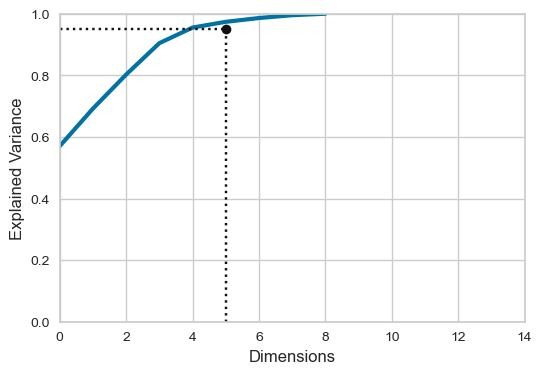

In [27]:
plt.figure(figsize=(6,4))
plt.plot(cm, linewidth=3)
plt.axis([0, 14, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([red, red], [0, 0.95], "k:")
plt.plot([0, red], [0.95, 0.95], "k:")
plt.plot(red, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [28]:
# PCA using n-component
pca2=PCA(n_components=5)
reduce_data=pca2.fit_transform(data_clean)

C:\Users\maddi\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maddi\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maddi\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\maddi\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_

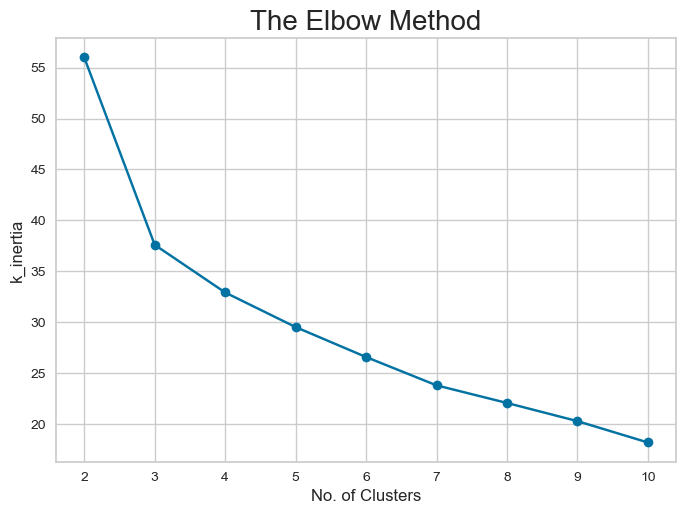

In [29]:
k_inertia = []
for i in range(2, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
    km.fit(reduce_data)
    k_inertia.append(km.inertia_)
    
plt.plot(range(2, 11), k_inertia, marker ="o")
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('k_inertia')
plt.show()

In [30]:
# model training
km= KMeans(n_clusters=3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 3)
km.fit(reduce_data)

C:\Users\maddi\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3, n_init=10, random_state=3)

In [31]:
# predict clusters
clusters = km.predict(reduce_data)

In [32]:
reduce_data.shape

(167, 5)

In [33]:
reduce_data = pd.DataFrame(reduce_data, columns=['PC1', 'PC2', 'PC3' , 'PC4','PC5'])
reduce_data.head()

,PC1,PC2,PC3,PC4,PC5
0,-0.828750,-0.239834,-0.045052,-0.247512,0.042036
1,0.030136,0.255057,-0.276633,0.145215,-0.022399
2,-0.118539,-0.001744,0.037725,0.449075,0.059480
3,-0.820331,-0.275233,0.687311,0.108067,0.066594
4,0.293014,0.227075,-0.048907,-0.001048,-0.111851


In [34]:
reduce_data['clusters'] = clusters
reduce_data.head()

,PC1,PC2,PC3,PC4,PC5,clusters
0,-0.828750,-0.239834,-0.045052,-0.247512,0.042036,0
1,0.030136,0.255057,-0.276633,0.145215,-0.022399,2
2,-0.118539,-0.001744,0.037725,0.449075,0.059480,2
3,-0.820331,-0.275233,0.687311,0.108067,0.066594,0
4,0.293014,0.227075,-0.048907,-0.001048,-0.111851,2


In [35]:
pca_df_cluster = pd.concat([df, reduce_data], axis=1)

In [36]:
pca_df_cluster.head(10)

,country,child_mortality,exports,health,imports,income,inflation,life_expectancy,total_fertility,gdpp,PC1,PC2,PC3,PC4,PC5,clusters
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,-0.828750,-0.239834,-0.045052,-0.247512,0.042036,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0.030136,0.255057,-0.276633,0.145215,-0.022399,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,-0.118539,-0.001744,0.037725,0.449075,0.059480,2
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,-0.820331,-0.275233,0.687311,0.108067,0.066594,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,0.293014,0.227075,-0.048907,-0.001048,-0.111851,2
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,0.054273,-0.295400,-0.187279,0.455816,0.336985,2
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,-0.108136,0.215605,-0.236383,0.297007,-0.076849,2
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,0.881044,-0.475365,-0.247963,-0.050209,-0.138755,1
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1.011619,-0.220404,-0.024443,-0.256844,0.066106,1
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,-0.063552,-0.015499,0.081025,0.314512,0.070242,2


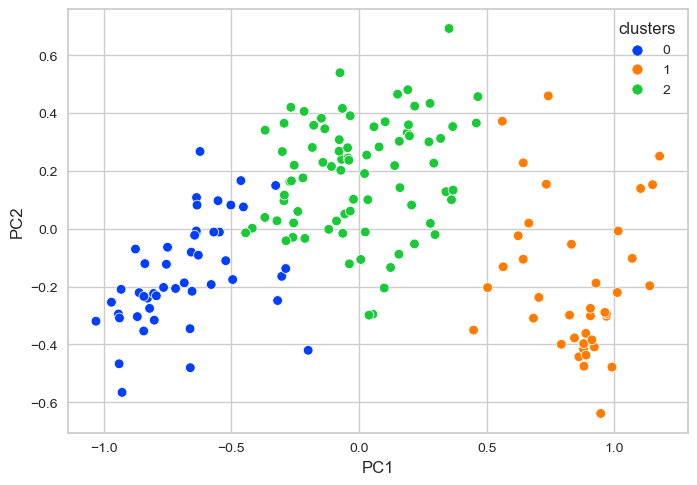

In [37]:
sns.scatterplot(data=pca_df_cluster, x="PC1", y="PC2", hue="clusters",palette="bright");

In [38]:
# count GDPP to each clusters
gdpp_by_cluster = pca_df_cluster.groupby('clusters')['gdpp'].sum()

# show result
print(gdpp_by_cluster)

clusters
0      85728
1    1596400
2     482886
Name: gdpp, dtype: int64


In [39]:
# count life-expectacy to each cluster
life_expectancy_by_cluster = pca_df_cluster.groupby('clusters')['life_expectancy'].mean()

# show result
print(life_expectancy_by_cluster)

clusters
0    59.606250
1    79.733333
2    72.651250
Name: life_expectancy, dtype: float64


In [40]:
# count income to each clusters
income_by_cluster = pca_df_cluster.groupby('clusters')['income'].sum()

# show result
print(income_by_cluster)

clusters
0     177823
1    1757800
2     927540
Name: income, dtype: int64


In [41]:
# count avg GDPP to each clusters
export_by_cluster = pca_df_cluster.groupby('clusters')['exports'].mean()

# show result
print(export_by_cluster)

clusters
0    27.948313
1    58.074359
2    40.734750
Name: exports, dtype: float64


In [42]:
cluster_0_countries = pca_df_cluster[pca_df_cluster['clusters'] == 0]['country']
print(cluster_0_countries)

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
49            Equatorial Guinea
50                      Eritrea
55                        Gabon
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
72                         Iraq
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
106                  Mozambique
107     

The names of countries that in clusters 0

Statement : 

* Cluster 0: This cluster has the lowest GDP per capita, income, and life expectancy. This indicates that countries in this cluster face extremely disadvantaged economic conditions, with low income and low life expectancy. This cluster requires special attention in efforts to improve economic development, increase income, and enhance the quality of life for its population.

* Cluster 1: This cluster has the highest GDP per capita, income, and life expectancy. This indicates that countries in this cluster have advanced economic conditions, high income, and high life expectancy. This cluster reflects countries with good economic development, good access to resources and healthcare services, and high quality of life for their population.

* Cluster 2: This cluster has the second highest or moderate levels of GDP per capita, income, and life expectancy. This indicates that countries in this cluster have relatively good economic conditions, moderate income, and relatively high life expectancy. Although not as good as Cluster 1, countries in this cluster still show a relatively good level of economic development and provide a decent quality of life for their population.


Recommendation: Cluster 0 is in dire need of assistance; therefore, the primary priority in sending aid should be to the countries in Cluster 0.

# 9. Model Saving

In [43]:
with open ('pca.pkl', 'wb') as file_1:
    pickle.dump(pca2, file_1)
with open ('kmeans.pkl', 'wb') as file_2:
    pickle.dump(km,file_2)

with open ('winsoriser.pkl', 'wb') as file_3:
    pickle.dump(winsorizer,file_3)
with open ('scaler.pkl','wb') as file_4:
    pickle.dump(scaler,file_4)